In [110]:
import numpy as np
import xtrack as xt
import xobjects as xo
import xpart as xp
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import constants 


line = xt.Line.from_json('sps.json')
particle_ref=line.particle_ref

line.build_tracker()
#line.freeze_longitudinal()
# line.optimize_for_tracking()

twiss=line.twiss()

clight=constants.speed_of_light
circumference = line.get_length()


#%%
###################
# Linear Transfer #
###################

qx=twiss['qx']
qy=twiss['qy']
dqx=twiss['dqx']
dqy=twiss['dqy']
circumference=twiss['s'][-1]
# beta_x=twiss['betx'][-1]
# beta_y=twiss['bety'][-1]

qs=twiss['qs']
bets=twiss['betz0']


#at interaction points: #from https://anaconda.org/petrenko/li_like_ca_in_sps/notebook
beta_x  =  54.614389 # m
beta_y  =  44.332517 # m
alpha_x = -1.535235
alpha_y =  1.314101

Dx  =  0*2.444732 # m
Dpx =  0*0.097522


Dy  =  0.0 # m
Dpy =  0.0

#index of gamma factory along SPS line: 16675

arc = xt.LineSegmentMap(
        qx=qx, qy=qy,
        dqx=0, dqy=0,
        length=circumference,
        alfx=alpha_x,
        alfy=alpha_y,
        betx=beta_x,
        bety=beta_y,
        
        dx=Dx,
        dpx=Dpx,
        dy=Dy,
        dpy=Dpy,
        qs=qs,
        bets=bets,
        )


Loading line from dict:   0%|          | 0/38786 [00:00<?, ?it/s]

Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [2]:
from ion_properties import ions,lead,calcium,xenon

print(lead.gamma_rel)
print(calcium.gamma_rel)


99.1881253075283
125.7995735607676


In [112]:
for ion in [calcium]:# Ion properties:
        q0 = ion.q0
        mass0 = ion.mass0

        gamma = ion.gamma_rel
        beta= ion.beta_rel
        p0c = mass0*gamma*beta #eV/c

        bunch_intensity = ion.Intensity

        particle_ref = xp.Particles(p0c=p0c, mass0=mass0, q0=q0)

        line.particle_ref=particle_ref

        nemitt = 1.5e-6 # m*rad (normalized emittance)
        sigma_z = 0.063 # m

        emittance=nemitt/(beta*gamma)

        num_particles=int(1e4)

        line_arc=xt.Line(
                elements=[arc])
        line_arc.build_tracker()

        particles = xp.generate_matched_gaussian_bunch(
                num_particles=num_particles,
                total_intensity_particles=bunch_intensity,
                nemitt_x=nemitt, nemitt_y=nemitt, sigma_z=sigma_z,
                particle_ref=particle_ref,
                line=line_arc,        
                )

        particles0=particles.copy()

        # sigma_dp=2e-4  
        sigma_dp=np.std(particles.delta)

        ##################
        # Laser Cooler #
        ##################

        #laser-ion beam collision angle
        theta_l = 2.6*np.pi/180 # rad
        nx = 0; ny = -np.sin(theta_l); nz = -np.cos(theta_l)

        # Ion excitation energy:
        ion_excited_lifetime=ion.excited_lifetime
        hw0 = ion.hw0 # eV
        hc=constants.hbar*clight/constants.e # eV*m (ħc)
        lambda_0 = 2*np.pi*hc/hw0 # m -- ion excitation wavelength

        lambda_l = lambda_0*gamma*(1 + beta*np.cos(theta_l)) # m -- laser wavelength

        # Shift laser wavelength for fast longitudinal cooling:
        lambda_l = lambda_l*(1+1*sigma_dp) # m

        laser_frequency = clight/lambda_l # Hz
        sigma_w = 2*np.pi*laser_frequency*sigma_dp
        #sigma_w = 2*np.pi*laser_frequency*sigma_dp/2 # for fast longitudinal cooling

        sigma_t = 1/sigma_w # sec -- Fourier-limited laser pulse
        print('Laser pulse duration sigma_t = %.2f ps' % (sigma_t/1e-12))
        print('Laser wavelength = %.2f nm' % (lambda_l/1e-9))

        laser_waist_radius = 1.3e-3 #m
        laser_energy = 5e-3

        laser_x = -1.7*1e-3

        GF_IP = xt.PulsedLaser(
                        laser_x=laser_x,
                        laser_y=0,
                        laser_z=0,
                        
                        laser_direction_nx = 0,
                        laser_direction_ny = ny,
                        laser_direction_nz = nz,
                        laser_energy         = laser_energy, # J
                        laser_duration_sigma = sigma_t, # sec
                        laser_wavelength = lambda_l, # m
                        laser_waist_radius = laser_waist_radius, # m
                        laser_waist_shift = 0, # m
                        ion_excitation_energy = hw0, # eV
                        ion_excited_lifetime  = ion_excited_lifetime, # sec                   
                        )

        # simulation parameters: simulate 10 s of cooling, and take data once every 100 ms
        max_time_s = 0.05
        int_time_s = 0.01
        T_per_turn = circumference/(clight*beta)
        num_turns = int(max_time_s/T_per_turn)
        save_interval = int(int_time_s/T_per_turn)


        # create a monitor object, to reduce holded data
        monitor = xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=1,
                                n_repetitions=int(num_turns/save_interval),
                                repetition_period=save_interval,
                                num_particles=num_particles)
                                    
        line = xt.Line(
                elements=[monitor,GF_IP,arc])
        
        line = xt.Line(
                elements=[monitor,arc])

        context = xo.ContextCpu(omp_num_threads=4)
        line.build_tracker(_context=context)

        line.track(particles, num_turns=100,
                turn_by_turn_monitor=True,with_progress=True)
        

        # extract relevant values
        x = line.record_last_track.x
        px =line.record_last_track.px
        y =line.record_last_track.y
        py =line.record_last_track.py
        delta=line.record_last_track.delta
        zeta =line.record_last_track.zeta
        state =line.record_last_track.state
                

        gamma_x=(1+alpha_x**2)/beta_x
        gamma_y=(1+alpha_y**2)/beta_y

        action_x = (gamma_x*(x-Dx*delta)**2 + 2*alpha_x*(x-Dx*delta)*(px-Dpx*delta)+ beta_x*(px-Dpx*delta)**2)
        action_y = (gamma_y*(y-Dy*delta)**2 + 2*alpha_y*(y-Dy*delta)*(py-Dpy*delta)+ beta_y*(py-Dpy*delta)**2)

        emittance_x=np.mean(action_x,axis=0)*gamma/2
        rms_dp_p=np.std(delta,axis=0)

        # # extract relevant values
        # x = monitor.x[:,:,0]
        # px = monitor.px[:,:,0]
        # y = monitor.y[:,:,0]
        # py = monitor.py[:,:,0]
        # delta = monitor.delta[:,:,0]
        # zeta = monitor.zeta[:,:,0]
        # state = monitor.state[:,:,0]
        # time = monitor.at_turn[:, 0, 0] * T_per_turn

        # gamma_x=(1+alpha_x**2)/beta_x
        # gamma_y=(1+alpha_y**2)/beta_y

        # action_x = (gamma_x*(x-Dx*delta)**2 + 2*alpha_x*(x-Dx*delta)*(px-Dpx*delta)+ beta_x*(px-Dpx*delta)**2)
        # action_y = (gamma_y*(y-Dy*delta)**2 + 2*alpha_y*(y-Dy*delta)*(py-Dpy*delta)+ beta_y*(py-Dpy*delta)**2)

        # emittance_x=np.mean(action_x,axis=1)*gamma/2
        # rms_dp_p=np.std(delta,axis=1)

        
        # np.savez(f'results/cooling_rates/transverse/{ion.name}.npz', x=x, px=px, y=y, py=py, zeta=zeta, delta=delta,
        #          action_x=action_x,action_y=action_y,emittance_x=emittance_x_twiss,state=state, time=time,s_per_turn=T_per_turn)

        #np.savez(f'results/cooling_rates/transverse/{ion.name}.npz', emittance_x=emittance_x_twiss,state=state, time=time,s_per_turn=T_per_turn)

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
*** Maximum RMS bunch length 0.2341172152804885m.
... distance to target bunch length: -6.3000e-02
... distance to target bunch length: 1.6465e-01
... distance to target bunch length: 7.8244e-02
... distance to target bunch length: -3.7042e-03
... distance to target bunch length: -7.4459e-05
... distance to target bunch length: -1.7742e-08
... distance to target bunch length: 3.0952e-07
--> Bunch length: 0.06299998225801984
--> Emittance: 0.11705764383376903
Laser pulse duration sigma_t = 5.73 ps
Laser wavelength = 899.99 nm
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/100 [00:00<?, ?it/s]

In [113]:
emittance_x.shape

(100,)

Transverse emittance

In [114]:
# from scipy.optimize import curve_fit
# #Define the exponential function
# def exponential_func(x, a, b):
#         return a * np.exp(x * b)

# # Fit the data to the exponential function
# params_transverse, covariance = curve_fit(exponential_func, time, emittance_x_twiss)

# plt.plot(time,emittance_x_twiss*1e6, linewidth=5.0)
# plt.plot(time, exponential_func(time,
#     *params_transverse) * 1e6, linestyle='--')

#print(cooling)

In [115]:
print(1/qs)

329.2145224574474


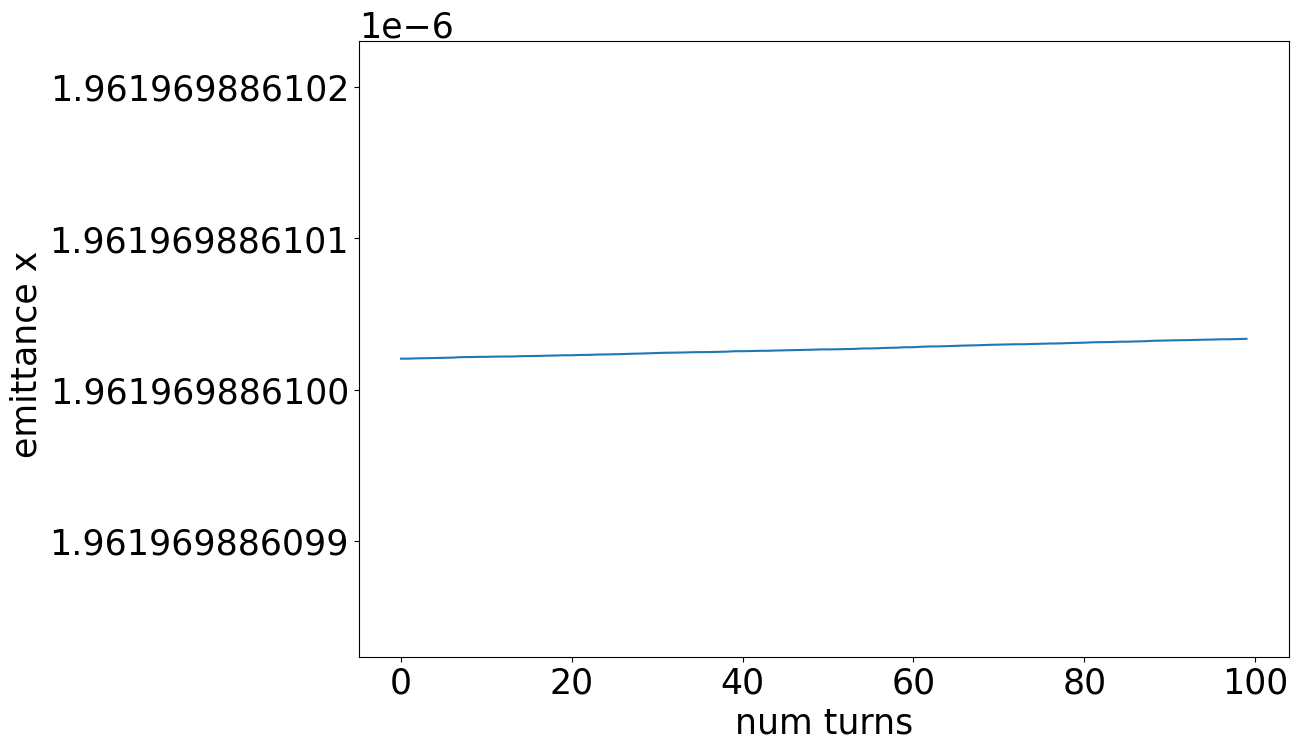

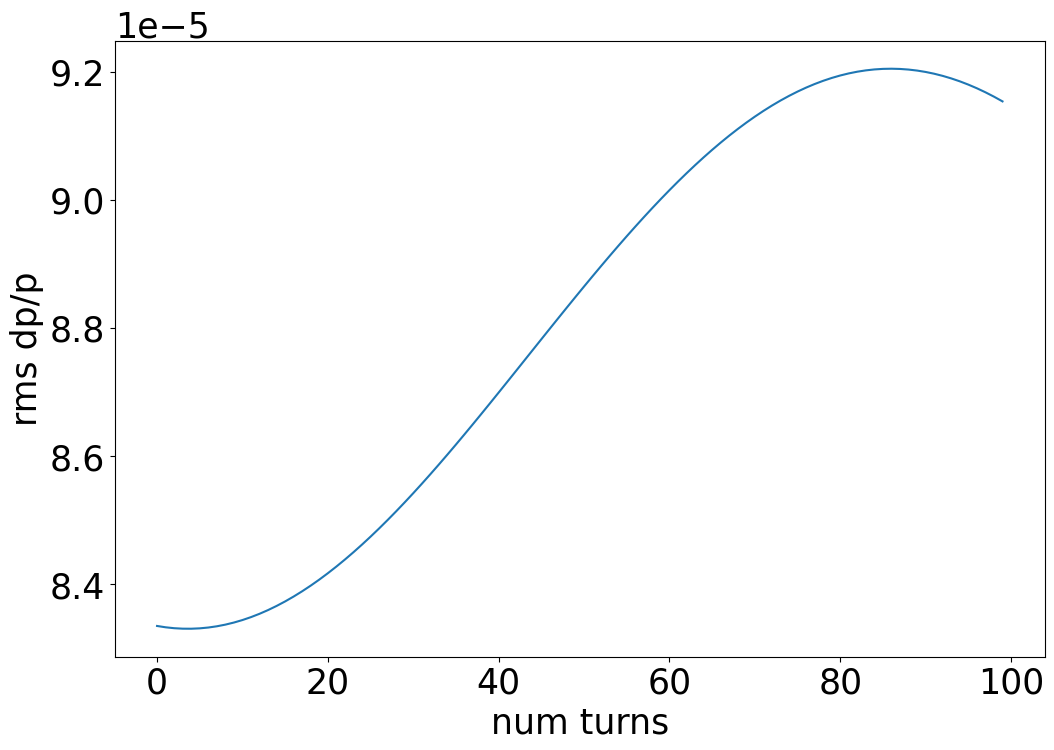

In [116]:
plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': 25})
plt.plot(emittance_x)

plt.xlabel('num turns')
plt.ylabel('emittance x ')
ax = plt.gca()
# Removing the offset from the y-axis tick labels
ax.yaxis.get_major_formatter().set_useOffset(False)
# plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.show()

plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': 25})
plt.plot(rms_dp_p)
plt.xlabel('num turns')
plt.ylabel('rms dp/p')
ax = plt.gca()
# Removing the offset from the y-axis tick labels
ax.yaxis.get_major_formatter().set_useOffset(False)
# plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.show()